In [1]:
#Import required packages
import matplotlib.pyplot as plt
import numpy as np
import torch 
import torch.nn as nn
import torch.optim as optim

from torch.autograd import grad
from torchdiffeq import odeint_adjoint
from torchdiffeq import odeint
import pandas as pd

In [2]:
#Define loss functions
#Simple MSE loss
def loss_fun_MSE(gt, pred):
    """Computes MSE loss"""
    return ((gt-pred)**2).mean()

#Custom loss function based on biological parameters
def loss_fun_bio(pred, alpha=1E7):
    """Computes scalarized loss including genetic constraint and product production"""
    j1 = pred[-1][-2]
    j2 = pred[-1][-1]
    loss = j1 + alpha*j2
    return loss

In [52]:
#Instantiate ODE systems
#Simple ODE function
class ODEFun(torch.nn.Module):
    def __init__(self):
        super(ODEFun, self).__init__()
        self.theta = torch.nn.Parameter(torch.tensor([0.0, 0.0]), requires_grad=True)
        
    def forward(self, t, y):
        S, I = y
        ds = -self.theta[0]*S*I
        di = self.theta[1]*S*I - I
        return torch.stack([ds, di])

#Stiff system
class StiffODE(torch.nn.Module):
    def __init__(self):
        super(StiffODE, self).__init__()
        self.W = torch.nn.Parameter(torch.tensor([1.]), requires_grad=True)

    def forward(self, t, y):
        dy = self.W*y**2 - y**3
        return torch.stack([dy])

#Adjustable stiff system
class AdjustStiffODE(torch.nn.Module):
    def __init__(self):
        super(AdjustStiffODE, self).__init__()
        self.theta = torch.nn.Parameter(torch.tensor([1.0, 1.0]), requires_grad=True)
        
    def forward(self, t, y):
        S = y
        ds = self.theta[0]*S**2 - self.theta[1]*S**3
        return ds

#Adjustable stiff system
class RandODE(torch.nn.Module):
    def __init__(self):
        super(RandODE, self).__init__()
        self.theta = torch.nn.Parameter(torch.tensor([np.random.rand(), np.random.rand()]), requires_grad=True)
        
    def forward(self, t, y):
        S = y
        ds = self.theta[0]*S**2 - self.theta[1]*S**3
        return ds
        
#Helper functions
def activation(x, k, theta, n):
    return (k*(x/theta)**n)/(1+(x/theta)**n)

def repression(x, k, theta, n):
    return k/(1+(x/theta)**n)

def nonlinearity(x, kc, km):
    return (kc*x)/(km+x)

#Biological System  
class UpstreamRepression(torch.nn.Module):
    def __init__(self):
        super(UpstreamRepression, self).__init__()
        #Initialize constants, taken from Verma et al paper.
        self.Vin = 1.
        self.e0 = 0.0467
        self.lam = 1.93E-4 #1/s
        #Assume equal kinetics for all three enzymes
        self.kc = 12
        self.km = 10 #1/s
        self.W = torch.nn.Parameter(torch.tensor([[2,2],[1,1], [1E-7, 1E-7]]), requires_grad=True)

    def forward(self, t, y):
        dx0 = self.Vin - self.lam*y[0] - self.e0*nonlinearity(y[0], self.kc, self.km) - self.lam*y[1]
        dx1 = y[2]*nonlinearity(y[0], self.kc, self.km) - y[3]*nonlinearity(y[1], self.kc, self.km) - self.lam*y[1]
        de1 = repression(y[1], self.W[2][0], self.W[1][0], self.W[0][0]) - self.lam*y[2]
        de2 = self.W[2][1] - self.lam*y[3]
        j1 = (self.Vin -  y[3]*nonlinearity(y[1], self.kc, self.km))**2
        j2 = repression(y[1], self.W[2][0], self.W[1][0], self.W[0][0])
        return torch.stack([dx0, dx1, de1, de2, j1, j2])

itr loss theta_0 theta_1
0 0.4809 0.1 0.1
10 0.4712 0.6093 0.7778
20 0.4438 1.006 1.3182
30 0.3735 1.367 1.7792
40 0.3035 1.6361 2.0912
50 0.2592 1.8355 2.3033
60 0.2296 1.9957 2.4659
70 0.2078 2.1314 2.6012
80 0.1907 2.2505 2.7194
90 0.1767 2.3576 2.8259
100 0.1649 2.4556 2.9242
110 0.1546 2.5464 3.0162
120 0.1456 2.6314 3.1034
130 0.1375 2.7116 3.1869
140 0.1301 2.7877 3.2673
150 0.1234 2.8603 3.3452
160 0.1172 2.9299 3.4211
170 0.1115 2.9967 3.4952
180 0.1062 3.0612 3.568
190 0.1011 3.1235 3.6396
200 0.0964 3.1838 3.7101
210 0.092 3.2424 3.7798
220 0.0878 3.2992 3.8488
230 0.0838 3.3545 3.9171
240 0.08 3.4083 3.9849
250 0.0764 3.4607 4.0523
260 0.073 3.5118 4.1192
270 0.0697 3.5617 4.1859
280 0.0665 3.6103 4.2522
290 0.0635 3.6577 4.3182
300 0.0606 3.704 4.384
310 0.0578 3.7492 4.4496
320 0.0552 3.7933 4.5151
330 0.0526 3.8363 4.5803
340 0.0502 3.8783 4.6454
350 0.0478 3.9192 4.7103
360 0.0455 3.9591 4.7751
370 0.0433 3.998 4.8397
380 0.0412 4.0359 4.9042
390 0.0392 4.0728 4.9685
40

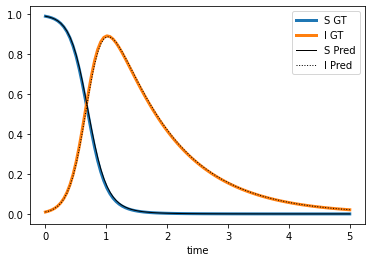

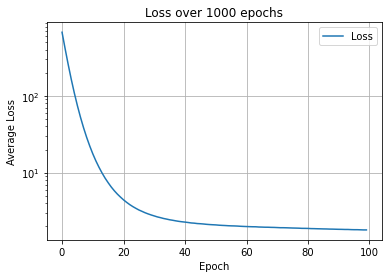

In [22]:
#Training a simple ODE system to match a predefined function works
func = ODEFun()
learning_rate = 0.01
num_iters = 1000
optimizer = torch.optim.RMSprop(func.parameters(), lr=learning_rate)
adjoint = False
alpha = 1E7
solver = 'dopri8'
int_time = 5

np.random.seed(2021)
torch.manual_seed(2021)
plt.close('all')

#Establish true values of function
def gt_fun(t, y):
    theta_0 = 5.5
    theta_1 = 8.0
    S, I = y
    ds = -theta_0*S*I
    di = theta_1*S*I - I
    return torch.stack([ds, di])
        
true_y0 = torch.tensor([0.99, 0.01])
t = torch.linspace(0, int_time, 100) 

with torch.no_grad():
    true_y = odeint(gt_fun, true_y0, t, method=solver)
    true_y_noise = true_y + torch.randn(true_y.shape)*0.02
    if adjoint == True:
        true_y_adj = odeint_adjoint(gt_fun, true_y0, t, method='dopri5')


#Gradient loop
print('itr loss theta_0 theta_1')
for ii in range(num_iters): 
    
    optimizer.zero_grad()
    
    pred = odeint(func, true_y0, t, method='dopri5')
    if adjoint == True:
        pred = odeint_adjoint(func, true_y0, t, method='dopri5')
    loss = loss_fun_MSE(true_y_noise, pred)
    
    loss.backward()
    optimizer.step()
    
    if ii % 10 == 0:
        print(ii, round(loss.item(), 4), round(func.theta[0].item(), 4), round(func.theta[1].item(), 4))
    
print('\n')
print('GT  : theta_0: {:2.2}, theta_1: {:2.2}'.format(5.5, 8.0))
print('Pred: theta_0: {:2.2}, theta_1: {:2.2}'.format(round(func.theta[0].item(), 4), round(func.theta[1].item(), 4)))

plt.figure(1)
with torch.no_grad():
    plt.plot(t, true_y[:,0], 'C0', lw=3, label='S GT')
    plt.plot(t, true_y[:,1], 'C1', lw=3, label='I GT')
    plt.plot(t, pred[:,0], 'k', lw=1, label='S Pred')
    plt.plot(t, pred[:,1], ':k', lw=1, label='I Pred')
plt.legend()
plt.xlabel('time')
plt.show()

#Plot losses 
plt.figure(2)
plt.semilogy(losses, label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.grid()
plt.legend()
plt.title('Loss over ' + str(num_iters) + ' epochs')
plt.show()


/var/folders/fz/1kd077v55dz4fd956zt4jrc40000gn/T/ipykernel_39656/1621189378.py:27: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim([0, 10E3])


Text(0, 0.5, 'Concentrations')

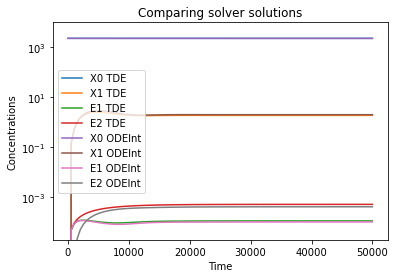

In [50]:
#We can instantiate a simple biological system and results match scipy solvers
#TorchDiffEQ solution
func = UpstreamRepression()
learning_rate = 0.01
num_iters = 1000
optimizer = torch.optim.RMSprop(func.parameters(), lr=learning_rate)
adjoint = False
alpha = 1E7
solver = 'dopri8'
int_time = 5E4
np.random.seed(2021)

#Establish initial conditions
t = torch.linspace(0, int_time, 100) 
y0 = torch.tensor([2290., 0., 0., 0., 0., 0.]) 

pred = odeint(func, y0, t, method=solver)

sol1 = pred.detach().numpy()
plt.figure(1)
plt.plot(t, sol1[:, 0], label='X0 TDE')
plt.plot(t, sol1[:, 1], label='X1 TDE')
plt.plot(t, sol1[:, 2], label='E1 TDE')
plt.plot(t, sol1[:, 3], label='E2 TDE')
plt.yscale('log')
plt.legend()
plt.ylim([0, 10E3])
plt.xlabel('Time')
plt.ylabel('Concentrations')
plt.title('Comparing solver solutions')

#Sample ODEint solver
#Plot solution and compare to traditional ODE solver
def dual_control(x, t, n1, n2, theta1, theta2, k1, k2):
    x0, x1, e1, e2, j1, j2 = x
    dx0dt = Vin - lam*x0 - e0*nonlinearity(x0, kc, km) - e1*nonlinearity(x0, kc, km) 
    dx1dt = e1*nonlinearity(x0, kc, km) - e2*nonlinearity(x1, kc, km) - lam*x1
    de1dt = repression(x1, k1, theta1, n1) - lam*e1
    de2dt = activation(x1, k2, theta2, n2) - lam*e2
    j1 = (Vin -  e2*nonlinearity(x1, kc, km))**2
    j2 = repression(x1, k1, theta1, n1) + activation(x1, k2, theta2, n2)
    return [dx0dt, dx1dt, de1dt, de2dt, j1, j2]  
from scipy.integrate import odeint as ode


Vin = func.Vin
e0 = func.e0 
lam = func.lam
kc = func.kc
km = func.km

n1 = 2
n2 = 2
theta1 = 1
theta2 = theta1
k1 = 1E-7
k2 = 1E-7
sol = ode(dual_control, y0, t, args=(n1, n2, theta1, theta2, k1, k2))

plt.figure(1)
plt.plot(t, sol[:, 0], label='X0 ODEInt')
plt.plot(t, sol[:, 1], label='X1 ODEInt')
plt.plot(t, sol[:, 2], label='E1 ODEInt')
plt.plot(t, sol[:, 3], label='E2 ODEInt')
plt.yscale('log')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Concentrations')

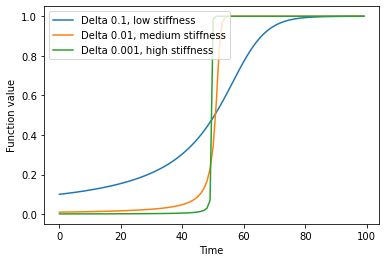

In [14]:
#A variably stiff system simplifies the problem further 
# but we start to get underflow errors with 'dopri8' solver - switched to dopri5
func = StiffODE()
learning_rate = 0.01
num_iters = 1000
optimizer = torch.optim.RMSprop(func.parameters(), lr=learning_rate)
adjoint = False
alpha = 1E7
solver = 'dopri5' 
int_time = 100
np.random.seed(2021)

delta = 0.1
y0 = torch.tensor([delta])
t = torch.linspace(0, 2/delta, 100, requires_grad=False) 
pred = odeint(func, y0, t, method=solver)

plt.plot(pred.detach().numpy(), label='Delta 0.1, low stiffness')

delta = 0.01
y0 = torch.tensor([delta])
t = torch.linspace(0, 2/delta, 100, requires_grad=False) 
pred = odeint(func, y0, t, method=solver)

plt.plot(pred.detach().numpy(), label='Delta 0.01, medium stiffness')

delta = 0.001
y0 = torch.tensor([delta])
t = torch.linspace(0, 2/delta, 100, requires_grad=False) 
pred = odeint(func, y0, t, method=solver)

plt.plot(pred.detach().numpy(), label='Delta 0.001, high stiffness')
plt.xlabel('Time')
plt.ylabel('Function value')
plt.legend()
plt.show()

In [22]:
#Establish gradient loop to train a more complex/stiff function
def true_fn(t, y):
    S = y
    ds = theta_0*S**2 - theta_1*S**3
    return ds

def train_fn(func, learning_rate, num_iters, solver, int_time, ic): 
    np.random.seed(2021)  
    optimizer = torch.optim.RMSprop(func.parameters(), lr=learning_rate)

    true_y0 = torch.tensor([ic])
    t = torch.linspace(0, int_time, 100) 

    with torch.no_grad():
        true_y = odeint(true_fn, true_y0, t, method=solver)
        true_y_noise = true_y + torch.randn(true_y.shape)*0.02
        #true_y_adj = odeint_adjoint(gt_fun, true_y0, t, method='dopri5')
    losses = []
    theta0s = []
    theta1s = []
    print('itr loss theta_0 theta_1')
    for ii in range(num_iters): 
        
        optimizer.zero_grad()
        
        #pred = odeint(func, true_y0, t, method='dopri5')
        pred = odeint_adjoint(func, true_y0, t, method=solver)
        loss = loss_fun_MSE(true_y_noise, pred)
        
        loss.backward()
        optimizer.step()
        
        if ii % 10 == 0:
            print(ii, round(loss.item(), 4), round(func.theta[0].item(), 4), round(func.theta[1].item(), 4))
            losses.append(loss.item())
            theta0s.append(func.theta[0].item())
            theta1s.append(func.theta[1].item())
            data = pd.DataFrame({'loss': losses, 'theta0': theta0s, 'theta1': theta1s})
            data.to_csv('solver_experiment_plots/'+str(func)+str(learning_rate)+'_'+str(num_iters)+'_'+str(solver)+'_'+str(int_time)+'_'+str(ic)+'_losses_temp.csv')

    # Note: here the GT values are hardcoded - fix
    print('\n')
    print('True  : theta_0: {:2.2}, theta_1: {:2.2}'.format(theta_0, theta_1))
    print('Pred: theta_0: {:2.2}, theta_1: {:2.2}'.format(round(func.theta[0].item(), 4), round(func.theta[1].item(), 4)))

    plt.figure(1)
    with torch.no_grad():
        plt.plot(t, true_y[:,0], 'C0', lw=3, label='S GT')
        plt.plot(t, pred[:,0], 'k', lw=1, label='S Pred')
    plt.legend()
    plt.xlabel('time') 
    plt.savefig('solver_experiment_plots/'+str(func)+str(learning_rate)+'_'+str(num_iters)+'_'+str(solver)+'_'+str(int_time)+'_'+str(ic)+'_func.png')
    plt.show()
    

    #Plot losses 
    plt.figure(2)
    plt.semilogy(losses, label='Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Average Loss')
    plt.grid()
    plt.legend()
    plt.title('Loss over ' + str(num_iters) + ' epochs')
    plt.savefig('solver_experiment_plots/'+str(func)+str(learning_rate)+'_'+str(num_iters)+'_'+str(solver)+'_'+str(int_time)+'_'+str(ic)+'_loss.png')
    plt.show()

itr loss theta_0 theta_1
0 0.0003 0.6043 0.7334
10 0.0003 0.5905 0.7334
20 0.0003 0.579 0.7334
30 0.0003 0.5687 0.7334
40 0.0003 0.559 0.7335
50 0.0003 0.5499 0.7335
60 0.0003 0.5412 0.7335
70 0.0003 0.5327 0.7335
80 0.0003 0.5245 0.7335
90 0.0003 0.5165 0.7336
100 0.0003 0.5087 0.7336
110 0.0003 0.501 0.7336
120 0.0003 0.4934 0.7336
130 0.0003 0.4859 0.7336
140 0.0003 0.4785 0.7337
150 0.0003 0.4712 0.7337
160 0.0003 0.4639 0.7337
170 0.0003 0.4567 0.7337
180 0.0003 0.4496 0.7337
190 0.0003 0.4425 0.7338
200 0.0003 0.4355 0.7338
210 0.0003 0.4284 0.7338
220 0.0003 0.4215 0.7338
230 0.0003 0.4145 0.7338
240 0.0003 0.4076 0.7339
250 0.0003 0.4007 0.7339
260 0.0003 0.3938 0.7339
270 0.0003 0.3869 0.7339
280 0.0003 0.3801 0.7339
290 0.0003 0.3732 0.734
300 0.0003 0.3664 0.734
310 0.0003 0.3596 0.734
320 0.0003 0.3528 0.734
330 0.0003 0.346 0.734
340 0.0003 0.3392 0.7341
350 0.0003 0.3324 0.7341
360 0.0003 0.3257 0.7341
370 0.0003 0.3189 0.7341
380 0.0003 0.3122 0.7342
390 0.0003 0.3054 0.

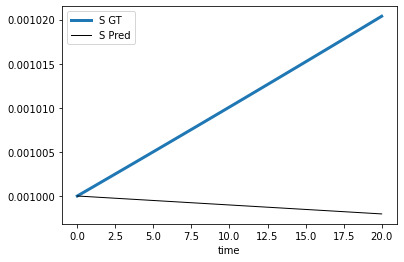

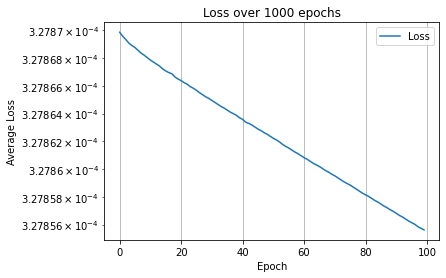

In [24]:
func = RandODE()
learning_rate = 1E-3
num_iters = 1000
solver = 'dopri5'
ic = 0.001 #Controls stiffness
int_time = 20

theta_0 = 1.0
theta_1 = 1.0
train_fn(func, learning_rate, num_iters, solver, int_time, ic)

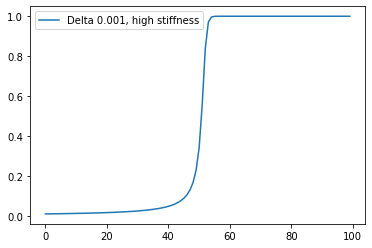

In [79]:
#Sanity check cell to manually plot function solutions
delta = 0.25
func = AdjustStiffODE()
y0 = torch.tensor([delta])
t = torch.linspace(0, 2/delta, 100, requires_grad=False) 

ic = 0.01
int_time = 2/ic
true_y0 = torch.tensor([ic])
t = torch.linspace(0, int_time, 100)
true_y = odeint(true_fn, true_y0, t, method=solver)

pred = odeint(func, y0, t, method=solver)

plt.plot(true_y.detach().numpy(), label='Delta 0.001, high stiffness')
plt.legend()
plt.show()



In [70]:
#Test run UpstreamRepression
func = UpstreamRepression()
learning_rate = 1E-4
num_iters = 100
solver = 'dopri5'
int_time = 5

# train_fn_bio(func, learning_rate, num_iters, solver, int_time)

np.random.seed(2021)  
optimizer = torch.optim.RMSprop(func.parameters(), lr=learning_rate)

t = torch.linspace(0, int_time, 100) 
true_y0 = torch.tensor([2290., 0., 0., 0., 0., 0.]) 

for i in range(10):
    pred = odeint_adjoint(func, true_y0, t, method=solver)
    loss = loss_fun_bio(pred)
    loss.backward()
    optimizer.step()
    print(loss.item())

10.0


AssertionError: underflow in dt nan